In [51]:
import pandas as pd
pd.set_option('display.max_rows', 1000)      # show 1000 rows
pd.set_option('display.max_columns', None)   # show all columns
pd.set_option('display.width', 2000)         # large width so it won’t wrap
pd.set_option('display.max_colwidth', None)  # don’t truncate cell text
# Basic
pr_df = pd.read_parquet("hf://datasets/hao-li/AIDev/pull_request.parquet")
# repo_df = pd.read_parquet("hf://datasets/hao-li/AIDev/repository.parquet")
# user_df = pd.read_parquet("hf://datasets/hao-li/AIDev/user.parquet")

# Comments and reviews
pr_comments_df = pd.read_parquet("hf://datasets/hao-li/AIDev/pr_comments.parquet")
pr_reviews_df = pd.read_parquet("hf://datasets/hao-li/AIDev/pr_reviews.parquet")
pr_review_comments_df = pd.read_parquet("hf://datasets/hao-li/AIDev/pr_review_comments.parquet")

# Commits
pr_commits_df = pd.read_parquet("hf://datasets/hao-li/AIDev/pr_commits.parquet")
pr_commit_details_df = pd.read_parquet("hf://datasets/hao-li/AIDev/pr_commit_details.parquet")

# # Related issues
# related_issue_df = pd.read_parquet("hf://datasets/hao-li/AIDev/related_issue.parquet")
# issue_df = pd.read_parquet("hf://datasets/hao-li/AIDev/issue.parquet")

# # Events
# pr_timeline_df = pd.read_parquet("hf://datasets/hao-li/AIDev/pr_timeline.parquet")

# # Task type
# pr_task_type_df = pd.read_parquet("hf://datasets/hao-li/AIDev/pr_task_type.parquet")

# # Human-PR
# human_pr_df = pd.read_parquet("hf://datasets/hao-li/AIDev/human_pull_request.parquet")
# human_pr_task_type_df = pd.read_parquet("hf://datasets/hao-li/AIDev/human_pr_task_type.parquet")

In [31]:
import re
from pathlib import PurePosixPath
from typing import Tuple

# Executable source code files (not config/docs/data)
CODE_EXTS = {
    ".py",".js",".jsx",".ts",".tsx",".go",".cs",".java",".kt",".kts",".rb",".php",
    ".cpp",".cc",".cxx",".c",".h",".hpp",".hh",".rs",".swift",".dart",".ps1",".jl",".R"
}

# Files that are config/docs/data
NONCODE_EXTS = {
    ".md",".rst",".adoc",".yml",".yaml",".toml",".ini",".cfg",".json",".lock",".txt",
    ".csv",".ipynb",".xml",".iml"
}

# Common test directories (case-insensitive, segment-bounded)
TEST_DIR_RE = re.compile(
    r"(?i)(^|/)(tests?|__tests__|specs?|e2e|integration(-?tests?)?|functional(-?tests?)?|acceptance|src/test)(/|$)"
)

# Testy filenames (case-insensitive)
TEST_FILE_RE = re.compile(
    r"(?i)(^test_.*|.*_test\.[^.]+$|.*\.test\.[^.]+$|.*\.spec\.[^.]+$|.*Tests?\.(cs|java|kt|kts|rb|php|scala|rs)$)"
)

# Support subtrees (fixtures, snapshots, resources, etc.)
SUPPORT_DIR_RE = re.compile(
    r"(?i)(^|/)(fixtures?|mocks?|stubs?|testdata|__snapshots__|data|resources)(/|$)"
)

# CI/config roots
CI_DIR_RE = re.compile(r"(?i)(^|/)(\.github|\.circleci|ci)(/|$)")

# Exact support basenames (configs that live alongside tests)
SUPPORT_BASENAMES = {
    "conftest.py","pytest.ini","tox.ini","pyproject.toml",
    "jest.config.js","jest.config.ts","vitest.config.js","vitest.config.ts","karma.conf.js",
    "tsconfig.json","package.json","package-lock.json","pnpm-lock.yaml","yarn.lock",
    "phpunit.xml","phpunit.xml.dist","pom.xml","build.gradle","build.gradle.kts",
    "requirements.txt","requirements-dev.txt",".pre-commit-config.yaml",".editorconfig"
}

# JVM resources specifically (never executable tests)
RESOURCES_DIR_RE = re.compile(r"(?i)(^|/)src/test/resources(/|$)")

# Tokens for test type (directory-only; content-free)
E2E_DIR_RE         = re.compile(r"(?i)(^|/)(e2e|acceptance|system|cypress/e2e|playwright/tests)(/|$)")
INTEGRATION_DIR_RE = re.compile(r"(?i)(^|/)(integration|functional|it)(/|$)")

In [32]:
def _norm_path(path: str) -> str:
    return path.replace("\\", "/").strip().lower()

def _suffix(path: str) -> str:
    return PurePosixPath(path).suffix.lower()

def classify_test_type(norm_path: str) -> str:
    if E2E_DIR_RE.search(norm_path):
        return "e2e"
    if INTEGRATION_DIR_RE.search(norm_path):
        return "integration"
    # If we're under a generic tests/ tree but no e2e/integration tokens, call it unit
    if TEST_DIR_RE.search(norm_path):
        return "unit"
    return "unspecified"

In [33]:
def classify_file(filename: str, additions: float = 0, deletions: float = 0,
                  status: str = "", min_loc_for_test: int = 0) -> Tuple[str, str]:
    """
    Returns (kind, test_type)

    kind: {'test','support','code','other'}
    test_type: {'unit','integration','e2e','unspecified'}  (only relevant when kind='test')
    """
    if not filename:
        return "other", "unspecified"
    p = _norm_path(filename)
    ext = _suffix(p)
    base = PurePosixPath(p).name
    loc_total = int((additions or 0) + (deletions or 0))

    # 1) Immediate SUPPORT (short-circuit)
    if CI_DIR_RE.search(p):
        return "support", "unspecified"
    if RESOURCES_DIR_RE.search(p):
        return "support", "unspecified"
    if base in SUPPORT_BASENAMES:
        return "support", "unspecified"
    if SUPPORT_DIR_RE.search(p):
        return "support", "unspecified"
    if ext in NONCODE_EXTS:
        return "support", "unspecified"

    # 2) TEST (path/filename + code extension, with optional tiny-change guard)
    looks_testy = TEST_DIR_RE.search(p) or TEST_FILE_RE.search(p)
    if looks_testy and ext in CODE_EXTS:
        if loc_total >= min_loc_for_test or status.lower() == "added":
            return "test", classify_test_type(p)
        # If you want to demote micro-changes to 'support', flip the next line:
        return "test", classify_test_type(p)

    # 3) Regular CODE
    if ext in CODE_EXTS:
        return "code", "unspecified"

    # 4) Everything else
    return "other", "unspecified"

In [72]:
import numpy as np

def classify_files_df(pr_commit_details_df: pd.DataFrame, min_loc_for_test: int = 0) -> pd.DataFrame:
    """Add columns: kind, test_type, loc, net_loc."""
    df = pr_commit_details_df.copy()
    # Robust numeric cols
    for col in ["additions","deletions"]:
        if col not in df: df[col] = 0
        df[col] = pd.to_numeric(df[col], errors="coerce").fillna(0)

    kinds, types = [], []
    for fn, add, dele, st in zip(df["filename"], df["additions"], df["deletions"], df.get("status","")):
        k, t = classify_file(fn, add, dele, st, min_loc_for_test=min_loc_for_test)
        kinds.append(k); types.append(t)

    df["kind"] = kinds
    df["test_type"] = types
    df["loc"] = df["additions"] + df["deletions"]
    df["net_loc"] = df["additions"] - df["deletions"]
    df["is_test"] = (df["kind"] == "test")
    df["is_new_test"] = df["is_test"] & (df.get("status","").str.lower() == "added")
    return df

def compute_agent_test_stats(pr_commit_details_df: pd.DataFrame,
                             pull_request_df: pd.DataFrame,
                             min_loc_for_test: int = 0):
    files = classify_files_df(pr_commit_details_df, min_loc_for_test=min_loc_for_test)

    # --- PR-level rollups ---
    pr_has_tests = files.groupby("pr_id")["is_test"].any().rename("has_tests_change")
    pr_test_net  = files.assign(test_net=np.where(files["is_test"], files["net_loc"], 0)).groupby("pr_id")["test_net"].sum()
    pr_test_loc  = files.assign(test_loc=np.where(files["is_test"], files["loc"], 0)).groupby("pr_id")["test_loc"].sum()
    pr_code_loc  = files.assign(code_loc=np.where(files["kind"]=="code", files["loc"], 0)).groupby("pr_id")["code_loc"].sum()
    pr_new_tests = files.assign(new_test=np.where(files["is_new_test"], 1, 0)).groupby("pr_id")["new_test"].sum()

    pr_summary = pd.concat([pr_has_tests, pr_test_net, pr_test_loc, pr_code_loc, pr_new_tests], axis=1).fillna(0)
    pr_summary["has_net_test_addition"] = pr_summary["test_net"] > 0

    # --- Attach agent; normalize strings to avoid merge mismatches ---
    pr_agents = pull_request_df[["id","agent"]].rename(columns={"id":"pr_id"}).copy()
    pr_agents["agent"] = pr_agents["agent"].astype(str).str.strip().fillna("(unknown)")

    pr_enriched = pr_summary.reset_index().merge(pr_agents, on="pr_id", how="left")
    pr_enriched["agent"] = pr_enriched["agent"].astype(str).str.strip().fillna("(unknown)")

    # A) PR-level per agent
    agent_pr_summary = (
        pr_enriched.groupby("agent", dropna=False)
        .agg(
            n_prs=("pr_id","count"),
            prs_with_tests=("has_tests_change","sum"),
            prs_with_net_test_add=("has_net_test_addition","sum"),
            median_new_test_files=("new_test","median"),
        )
        .reset_index()
    )
    agent_pr_summary["pct_prs_with_tests"]      = 100.0 * agent_pr_summary["prs_with_tests"]      / agent_pr_summary["n_prs"].replace(0, np.nan)
    agent_pr_summary["pct_prs_with_net_test_add"]= 100.0 * agent_pr_summary["prs_with_net_test_add"] / agent_pr_summary["n_prs"].replace(0, np.nan)
    agent_pr_summary[["pct_prs_with_tests","pct_prs_with_net_test_add"]] = agent_pr_summary[["pct_prs_with_tests","pct_prs_with_net_test_add"]].fillna(0.0)

    # B) File-weighted type share
    test_files = files[files["kind"]=="test"].merge(pr_agents, on="pr_id", how="left")
    test_files["agent"] = test_files["agent"].astype(str).str.strip().fillna("(unknown)")

    if not test_files.empty:
        type_counts = (
            test_files.groupby(["agent","test_type"]).size().reset_index(name="n_test_files")
        )
        total_by_agent = type_counts.groupby("agent", as_index=False)["n_test_files"].sum().rename(columns={"n_test_files":"total_files"})
        agent_type_pct_files = type_counts.merge(total_by_agent, on="agent", how="left")
        agent_type_pct_files["pct_of_agent_test_files"] = 100.0 * agent_type_pct_files["n_test_files"] / agent_type_pct_files["total_files"].replace(0, np.nan)
        agent_type_pct_files["pct_of_agent_test_files"] = agent_type_pct_files["pct_of_agent_test_files"].fillna(0.0)
    else:
        agent_type_pct_files = pd.DataFrame(columns=["agent","test_type","n_test_files","total_files","pct_of_agent_test_files"])

    # C) PR-dominant type share (PR-weighted)
    if not test_files.empty:
        pr_type_counts = test_files.groupby(["pr_id","test_type"]).size().reset_index(name="cnt")
        idx = pr_type_counts.groupby("pr_id")["cnt"].idxmax()
        pr_dominant = pr_type_counts.loc[idx, ["pr_id","test_type"]].rename(columns={"test_type":"dominant_type"})
        pr_dom_enriched = pr_dominant.merge(pr_agents, on="pr_id", how="left")
        pr_dom_enriched["agent"] = pr_dom_enriched["agent"].astype(str).str.strip().fillna("(unknown)")

        agent_type_pct_pr_dominant = (
            pr_dom_enriched.groupby(["agent","dominant_type"]).size().reset_index(name="n_prs_dominant")
        )

        # total PRs with tests per agent (denominator)
        totals = (
            pr_enriched[pr_enriched["has_tests_change"]]
            .groupby("agent", as_index=False)["pr_id"].count()
            .rename(columns={"pr_id":"total_prs_with_tests"})
        )

        agent_type_pct_pr_dominant = agent_type_pct_pr_dominant.merge(totals, on="agent", how="left")
        agent_type_pct_pr_dominant["pct_of_agent_prs_with_tests"] = (
            100.0 * agent_type_pct_pr_dominant["n_prs_dominant"] /
            agent_type_pct_pr_dominant["total_prs_with_tests"].replace(0, np.nan)
        )
        agent_type_pct_pr_dominant["pct_of_agent_prs_with_tests"] = agent_type_pct_pr_dominant["pct_of_agent_prs_with_tests"].fillna(0.0)
    else:
        agent_type_pct_pr_dominant = pd.DataFrame(
            columns=["agent","dominant_type","n_prs_dominant","total_prs_with_tests","pct_of_agent_prs_with_tests"]
        )

    return files, pr_enriched, agent_pr_summary, agent_type_pct_files, agent_type_pct_pr_dominant



In [73]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import os
import numpy as np
import matplotlib.pyplot as plt

def _label_bars(ax, fmt="{:.0f}%"):
    for p in ax.patches:
        h = p.get_height()
        if h is None or np.isnan(h): 
            continue
        ax.annotate(fmt.format(h),
                    (p.get_x() + p.get_width()/2.0, h),
                    ha="center", va="bottom", fontsize=9)

def _ensure_dir_for(path: str):
    if path is None:
        return
    directory = os.path.dirname(path)
    if directory and not os.path.exists(directory):
        os.makedirs(directory, exist_ok=True)

def plot_agent_pr_frequencies(agent_pr_summary, top_n: int = 12, savepath: str = None, title_suffix: str = ""):
    df = agent_pr_summary.sort_values("n_prs", ascending=False).head(top_n)
    # Chart 1
    plt.figure(figsize=(10, 6))
    plt.bar(df["agent"], df["pct_prs_with_tests"])
    _label_bars(plt.gca()) 
    plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: f"{y:.0f}%"))
    plt.title(f"Agents: % of PRs with any test change{title_suffix}")
    plt.xlabel("Agent")
    plt.ylabel("% of PRs")
    plt.xticks(rotation=30, ha="right")
    plt.tight_layout()
    if savepath:
        p = savepath.replace(".png", "_with_tests.png")
        _ensure_dir_for(p)
        plt.savefig(p, dpi=200)
    plt.show()
    # Chart 2
    plt.figure(figsize=(10, 6))
    plt.bar(df["agent"], df["pct_prs_with_net_test_add"])
    _label_bars(plt.gca()) 
    plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: f"{y:.0f}%"))
    plt.title(f"Agents: % of PRs with net test addition{title_suffix}")
    plt.xlabel("Agent")
    plt.ylabel("% of PRs")
    plt.xticks(rotation=30, ha="right")
    plt.tight_layout()
    if savepath:
        p = savepath.replace(".png", "_with_net_add.png")
        _ensure_dir_for(p)
        plt.savefig(p, dpi=200)
    plt.show()

def plot_agent_type_shares_files(agent_type_pct_files, top_n_agents: int = 12, savepath: str = None, title_suffix: str = ""):
    top_agents = (agent_type_pct_files.groupby("agent")["n_test_files"].sum().sort_values(ascending=False).head(top_n_agents).index)
    dfp = agent_type_pct_files[agent_type_pct_files["agent"].isin(top_agents)].pivot(index="agent", columns="test_type", values="pct_of_agent_test_files").fillna(0)
    dfp = dfp.sort_values(by=dfp.columns.tolist(), ascending=False)

    plt.figure(figsize=(12, 7))
    x = np.arange(len(dfp.index))
    width = 0.8 / max(1, len(dfp.columns))
    for i, col in enumerate(dfp.columns):
        plt.bar(x + i*width, dfp[col].values, width=width, label=col)
        _label_bars(plt.gca()) 
    plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: f"{y:.0f}%"))
    plt.title(f"Test type distribution by agent (file-weighted){title_suffix}")
    plt.xlabel("Agent")
    plt.ylabel("% of test files")
    plt.xticks(x + (len(dfp.columns)-1)*width/2, dfp.index, rotation=30, ha="right")
    plt.legend(title="Test type")
    plt.tight_layout()
    if savepath:
        p = savepath.replace(".png", "_type_share_files.png")
        _ensure_dir_for(p)
        plt.savefig(p, dpi=200)
    plt.show()

def plot_agent_type_shares_pr(agent_type_pct_pr_dominant, top_n_agents: int = 12, savepath: str = None, title_suffix: str = ""):
    top_agents = (agent_type_pct_pr_dominant.groupby("agent")["n_prs_dominant"].sum().sort_values(ascending=False).head(top_n_agents).index)
    dfp = agent_type_pct_pr_dominant[agent_type_pct_pr_dominant["agent"].isin(top_agents)].pivot(index="agent", columns="dominant_type", values="pct_of_agent_prs_with_tests").fillna(0)
    dfp = dfp.sort_values(by=dfp.columns.tolist(), ascending=False)

    plt.figure(figsize=(12, 7))
    x = np.arange(len(dfp.index))
    width = 0.8 / max(1, len(dfp.columns))
    for i, col in enumerate(dfp.columns):
        plt.bar(x + i*width, dfp[col].values, width=width, label=col)
        _label_bars(plt.gca()) 
    plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: f"{y:.0f}%"))
    plt.title(f"Dominant test type share by agent (PR-weighted){title_suffix}")
    plt.xlabel("Agent")
    plt.ylabel("% of PRs with tests")
    plt.xticks(x + (len(dfp.columns)-1)*width/2, dfp.index, rotation=30, ha="right")
    plt.legend(title="Dominant type")
    plt.tight_layout()
    if savepath:
        p = savepath.replace(".png", "_type_share_pr.png")
        _ensure_dir_for(p)
        plt.savefig(p, dpi=200)
    plt.show()

In [ ]:
def visualize_agent_test_stats(pr_commit_details_df: pd.DataFrame, pull_request_df: pd.DataFrame,
                               min_loc_for_test: int = 4, top_n_agents: int = 5, save_prefix: str = "snapshots/agent_tests"):
    """
    Computes metrics and renders 4 charts:
      1) % of PRs with any test change (by agent)
      2) % of PRs with net test addition (by agent)
      3) Test type distribution (file-weighted) by agent
      4) Dominant test type share (PR-weighted) by agent

    Also returns the three summary tables.
    """
    files, pr_enriched, agent_pr_summary, agent_type_pct_files, agent_type_pct_pr_dominant = compute_agent_test_stats(
        pr_commit_details_df, pull_request_df, min_loc_for_test=min_loc_for_test
    )

    # Plots
    plot_agent_pr_frequencies(agent_pr_summary, top_n=top_n_agents, savepath=f"{save_prefix}.png")
    if not agent_type_pct_files.empty:
        plot_agent_type_shares_files(agent_type_pct_files, top_n_agents=top_n_agents, savepath=f"{save_prefix}.png")
    if not agent_type_pct_pr_dominant.empty:
        plot_agent_type_shares_pr(agent_type_pct_pr_dominant, top_n_agents=top_n_agents, savepath=f"{save_prefix}.png")

    # Return dataframes for further use
    return agent_pr_summary, agent_type_pct_files, agent_type_pct_pr_dominant

In [52]:
def apply_fixes_commits(
    pr_commit_details_df: pd.DataFrame,
    csv_path: str = "fixed_commits.csv",
    sha_col: str = "sha",
    pr_id_col: str = "pr_id"
):
    """
    - Removes ALL rows in pr_commit_details_df whose (sha, pr_id) appear in the CSV
    - Appends EVERY row from the CSV (no dedup)
    - Returns (updated_df, summary_df)
    """
    # Load CSV exactly as-is (keep duplicates)
    fixes = pd.read_csv(csv_path)

    # Basic checks
    for col in (sha_col, pr_id_col):
        if col not in pr_commit_details_df.columns:
            raise KeyError(f"'pr_commit_details_df' is missing required column: {col}")
        if col not in fixes.columns:
            raise KeyError(f"CSV is missing required column: {col}")

    # Metrics before mutation
    original_rows = len(pr_commit_details_df)
    csv_rows = len(fixes)

    # Keys for matching (as strings)
    base = pr_commit_details_df.copy()
    base_key  = base[sha_col].astype(str)  + "|" + base[pr_id_col].astype(str)
    fixes_key = fixes[sha_col].astype(str) + "|" + fixes[pr_id_col].astype(str)

    # Remove ALL base rows whose key appears in CSV (CSV may have duplicates; that's fine)
    to_remove_keys = set(fixes_key.tolist())
    removed_mask = base_key.isin(to_remove_keys)
    rows_removed_from_original = int(removed_mask.sum())
    base_kept = base.loc[~removed_mask].copy()

    # Column union (add missing columns to each side as NA)
    all_cols = list(dict.fromkeys(list(base_kept.columns) + list(fixes.columns)))
    for c in all_cols:
        if c not in base_kept.columns:
            base_kept[c] = pd.NA
        if c not in fixes.columns:
            fixes[c] = pd.NA
    base_kept = base_kept[all_cols]
    fixes = fixes[all_cols]

    # Append EVERY row from CSV
    updated = pd.concat([base_kept, fixes], ignore_index=True)
    final_rows = len(updated)

    # Old-style summary (we did not drop CSV duplicates, so it's 0)
    summary = pd.DataFrame({
        "metric": [
            "original_rows",
            "csv_rows",
            "csv_dupe_keys_dropped",
            "rows_removed_from_original",
            "final_rows",
        ],
        "value": [
            original_rows,
            csv_rows,
            0,  # we intentionally do NOT drop any duplicate keys from the CSV
            rows_removed_from_original,
            final_rows,
        ],
    })

    return updated, summary

In [53]:
pr_commit_details_fixed_df, summary = apply_fixes_commits(
    pr_commit_details_df,
    csv_path="../fixed_commits.csv",
    sha_col="sha",
    pr_id_col="pr_id"
)

summary

,metric,value
0,original_rows,711923
1,csv_rows,181511
2,csv_dupe_keys_dropped,0
3,rows_removed_from_original,181511
4,final_rows,711923


Note: could not render interactive tables; proceeding with plots. Error: No module named 'caas_jupyter_tools'


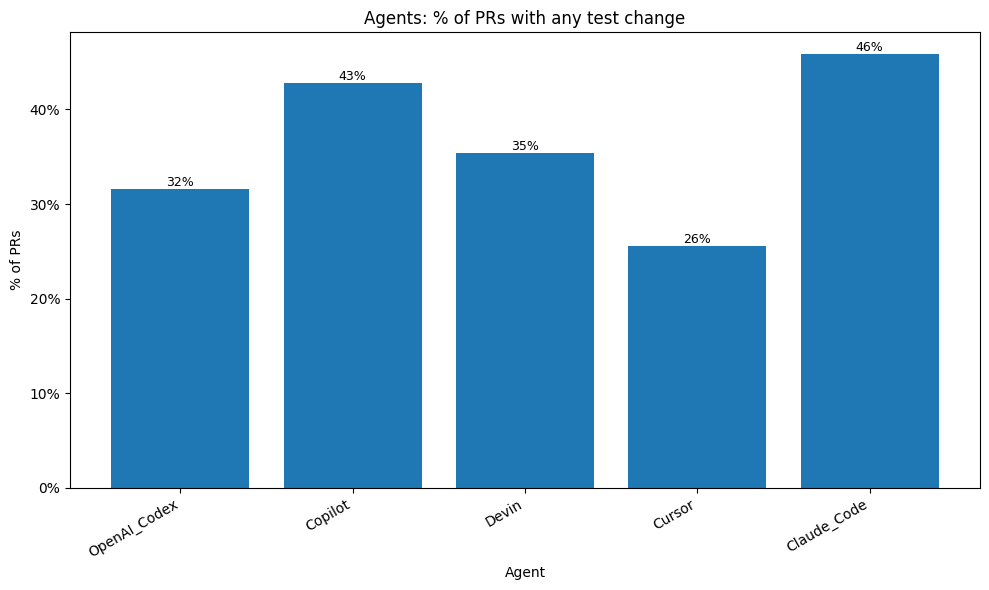

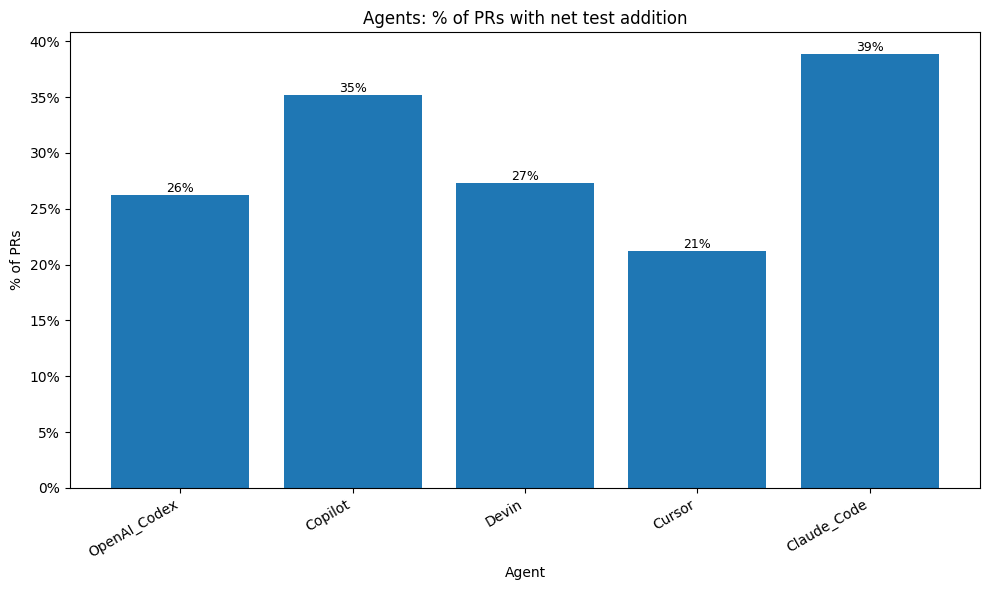

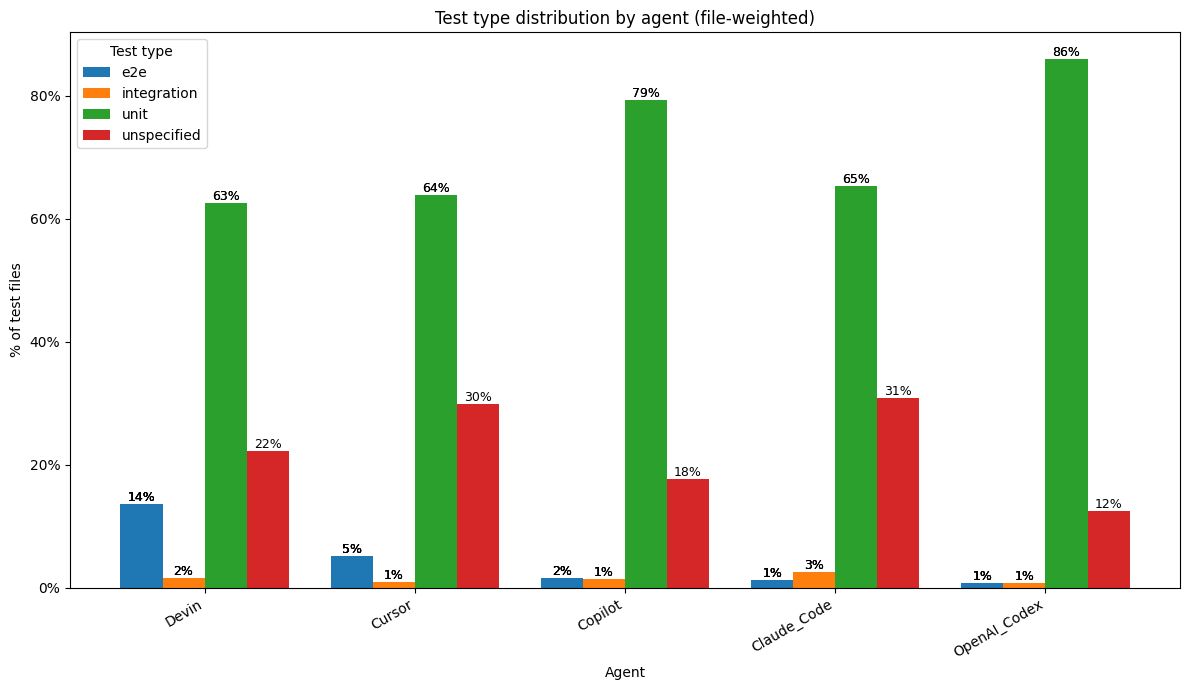

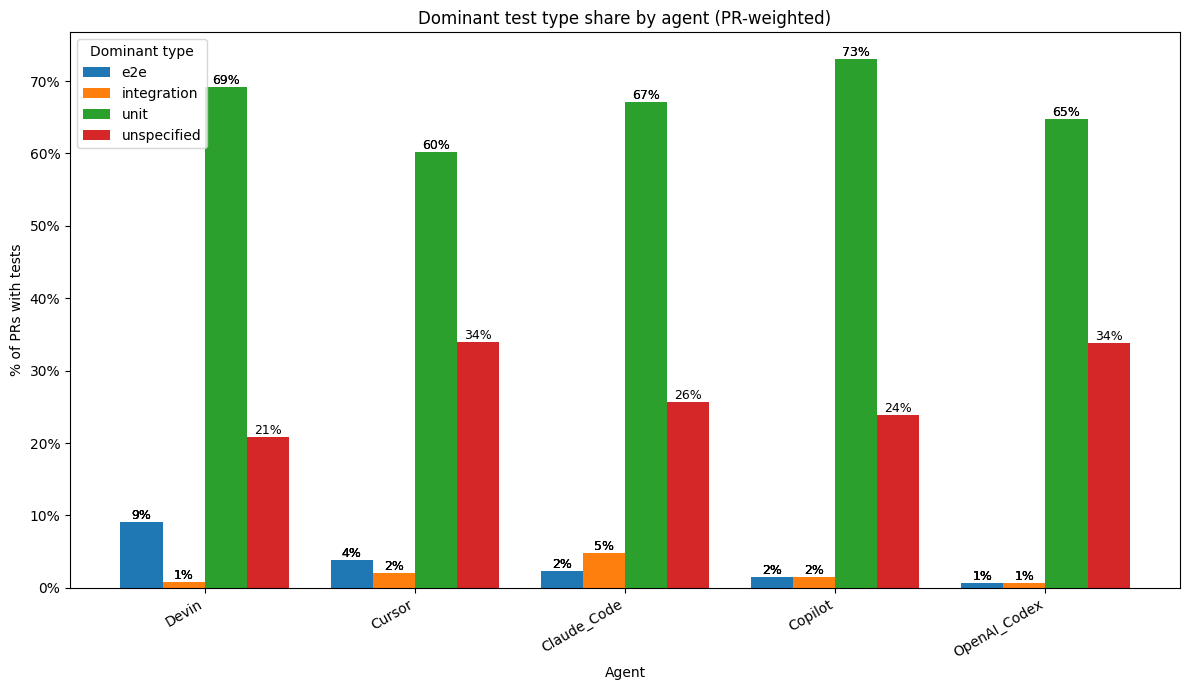

In [ ]:
_, _, _ = visualize_agent_test_stats(pr_commit_details_fixed_df, pr_df, min_loc_for_test=4, top_n_agents=5)